In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, cv2, random, json, itertools

from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, 
                                    MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [2]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    
    ax[0].plot(history.history['loss'], label="Training Loss")
    ax[0].plot(history.history['val_loss'], label="Validation Loss")
    ax[1].plot(history.history['accuracy'], label="Training Accuracy")
    ax[1].plot(history.history['val_accuracy'], label="Validation Accuracy")
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    
    plt.show();
    pass

In [3]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.0
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j,i, format(cm[i,j], fmt),
                horizontalalignment = "center",
                color = "white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.grid(None);
    pass

In [4]:
dataset_path = "../input/landuse-scene-classification/images"

with open("../input/landuse-scene-classification/label_map.json","r") as file:
    class_name_binarized = json.load(file)

num_classes = len(class_name_binarized)
class_names = list(class_name_binarized.keys())
class_name_binarized

{'agricultural': 0,
 'airplane': 1,
 'baseballdiamond': 2,
 'beach': 3,
 'buildings': 4,
 'chaparral': 5,
 'denseresidential': 6,
 'forest': 7,
 'freeway': 8,
 'golfcourse': 9,
 'intersection': 10,
 'mediumresidential': 11,
 'mobilehomepark': 12,
 'overpass': 13,
 'parkinglot': 14,
 'river': 15,
 'runway': 16,
 'sparseresidential': 17,
 'storagetanks': 18,
 'tenniscourt': 19,
 'harbor': 20}

In [5]:
def load_data(csv_file):
    images, labels = [], []
    
    data = pd.read_csv(csv_file,index_col="Unnamed: 0")
    
    for i in tqdm(range(data.shape[0])):
        
        img_name = data.loc[i,'Filename']
        img = load_img(os.path.join(dataset_path,img_name),target_size=(224,224))
        img = img_to_array(img)
        
        img = preprocess_input(img)
        label = data.loc[i,'Label']
        
        images.append(img)
        labels.append(label)
        pass
    
    images = np.array(images)
    labels = np.array(labels)
    return images, labels
    pass

In [6]:
train_images, train_labels = load_data("../input/landuse-scene-classification/train.csv")
val_images, val_labels = load_data("../input/landuse-scene-classification/validation.csv")

train_images.shape, train_labels.shape, val_images.shape, val_labels.shape

100%|██████████| 2100/2100 [00:09<00:00, 211.80it/s]


((7350, 224, 224, 3), (7350,), (2100, 224, 224, 3), (2100,))

In [7]:
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)

train_labels.shape, val_labels.shape

((7350, 21), (2100, 21))

In [ ]:
def conv_block(X,k,filters,stage,block,s=2):
    
    conv_base_name = 'conv_' + str(stage) + block + '_branch'
    bn_base_name = 'bn_' + str(stage) + block + '_branch'
    ac_base_name = 'ac_' + str(stage) + block + '_branch'
    
    F1 = filters
    
    X = Conv2D(filters=F1, kernel_size=(k,k), strides=(s,s),
              padding='same', name=conv_base_name+'2a')(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation("relu", name=ac_base_name+'2a')(X)
    
    return X
    pass

In [ ]:
def conv_model(input_shape, classes):
    
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((5,5),name="zero_padding_1")(X_input)
    
    X = Conv2D(16,(3,3), strides=(2,2), name='conv1', padding="same")(X)
    X = BatchNormalization(name="bn_conv1")(X)
    
    X = conv_block(X,3,32,2,block='A',s=1)
    X = MaxPooling2D((2,2), name="max_pooling_2")(X)
    X = Dropout(0.25, name="dropout_2")(X)
    
    X = conv_block(X,5,32,3,block='A',s=2)
    X = MaxPooling2D((2,2), name="max_pooling_3")(X)
    X = Dropout(0.25, name="dropout_3")(X)
    
    X = conv_block(X,3,64,4,block='A',s=1)
    X = MaxPooling2D((2,2), name="max_pooling_4")(X)
    X = Dropout(0.25, name="dropout_4")(X)
    
    X = Flatten(name="flatten_1")(X)
    X = Dense(64,name="dense_1")(X)
    X = Activation("relu",name="dense_relu_1")(X)
    
    X = Dense(128,name="dense_2")(X)
    X = Activation("relu", name="dense_relu_2")(X)
    
    X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)
    
    model = Model(inputs=X_input, outputs=X, name="Basic_Conv_model")
    
    return model
    pass

In [ ]:
model = conv_model(input_shape=(224,224,3),classes=num_classes)

In [ ]:
plot_model(model,to_file='basic_conv_model.png',show_shapes=True,show_layer_names=True)
SVG(model_to_dot(model).create(prog='dot',format='svg'))

model.summary()

In [ ]:
opt = Adam(lr=1e-3)
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
logs = TensorBoard("logs")

In [ ]:
epochs = 50
batch_size = 10

history = model.fit(train_images, train_labels,
                   steps_per_epoch=len(train_images)//batch_size,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(val_images, val_labels),
                   validation_steps=len(val_images)//batch_size,
                   callbacks=[checkpoint, logs])

In [ ]:
show_final_history(history)

In [ ]:
val_pred = model.predict(val_images)
val_pred = np.argmax(val_pred, axis=1)
val_pred.shape

In [ ]:
val_actual = np.argmax(val_labels, axis=1)

cnf_mat = confusion_matrix(val_actual, val_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat, classes=class_names)
plt.grid(None)
plt.show();

In [ ]:
train_dir = "../input/landuse-scene-classification/images_train_test_val/train"
val_dir = "../input/landuse-scene-classification/images_train_test_val/validation"

batchSize = 10

IGD = ImageDataGenerator(rescale=1./255.)

train_generator = IGD.flow_from_directory(train_dir,
                                         target_size=(224,224),
                                         color_mode='rgb',
                                         batch_size=batchSize,
                                         class_mode='categorical',
                                         shuffle=True,
                                         seed=42)

val_generator = IGD.flow_from_directory(val_dir,
                                        target_size=(224,224),
                                        color_mode='rgb',
                                        batch_size=batchSize,
                                        class_mode='categorical',
                                        shuffle=True,
                                        seed=42)

In [8]:
model_1 = MobileNet(weights="imagenet",include_top=False,input_shape=(224,224,3))

for layer in model_1.layers:
    layer.trainable = False

model_1.summary()

17227776/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________

In [9]:
headModel = model_1.output
headModel = AveragePooling2D(pool_size=(7,7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128,activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)

model_2 = Model(inputs=model_1.input, outputs=headModel)

model_2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [10]:
opt_2 = Adam(lr=1e-3)
model_2.compile(loss="categorical_crossentropy",optimizer=opt_2,metrics=['accuracy'])

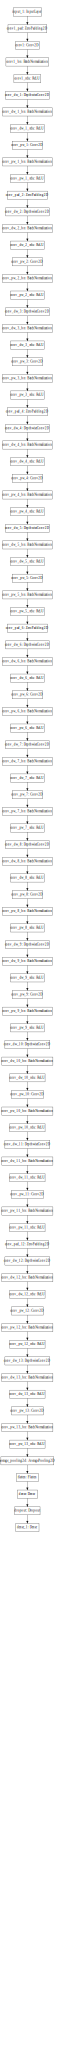

In [11]:
plot_model(model_2,to_file='MobileNet_transfer_model.png',show_shapes=True,show_layer_names=True)
SVG(model_to_dot(model_2).create(prog='dot',format='svg'))

In [12]:
MobileNet_checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
MobileNet_logs = TensorBoard("MobileNet-transfer-logs")

In [14]:
epochs = 30
batchSize = 10

history = model_2.fit(train_images, train_labels,
                      steps_per_epoch=len(train_images)//batchSize,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(val_images,val_labels),
                      validation_steps=len(val_images)//batchSize,
                      callbacks=[MobileNet_checkpoint, MobileNet_logs])

Epoch 1/30
735/735 [==============================] - ETA: 0s - loss: 0.9407 - accuracy: 0.7086
Epoch 00001: val_accuracy improved from -inf to 0.92619, saving model to model_weights.h5
735/735 [==============================] - 163s 222ms/step - loss: 0.9407 - accuracy: 0.7086 - val_loss: 0.2645 - val_accuracy: 0.9262
Epoch 2/30
735/735 [==============================] - ETA: 0s - loss: 0.3506 - accuracy: 0.8807
Epoch 00002: val_accuracy improved from 0.92619 to 0.94048, saving model to model_weights.h5
735/735 [==============================] - 167s 228ms/step - loss: 0.3506 - accuracy: 0.8807 - val_loss: 0.1850 - val_accuracy: 0.9405
Epoch 3/30
735/735 [==============================] - ETA: 0s - loss: 0.2540 - accuracy: 0.9152
Epoch 00003: val_accuracy improved from 0.94048 to 0.96000, saving model to model_weights.h5
735/735 [==============================] - 167s 227ms/step - loss: 0.2540 - accuracy: 0.9152 - val_loss: 0.1362 - val_accuracy: 0.9600
Epoch 4/30
735/735 [===========

Epoch 29/30
735/735 [==============================] - ETA: 0s - loss: 0.0520 - accuracy: 0.9816
Epoch 00029: val_accuracy did not improve from 0.97429
735/735 [==============================] - 166s 226ms/step - loss: 0.0520 - accuracy: 0.9816 - val_loss: 0.1203 - val_accuracy: 0.9729
Epoch 30/30
735/735 [==============================] - ETA: 0s - loss: 0.0594 - accuracy: 0.9812
Epoch 00030: val_accuracy improved from 0.97429 to 0.97667, saving model to model_weights.h5
735/735 [==============================] - 167s 227ms/step - loss: 0.0594 - accuracy: 0.9812 - val_loss: 0.0934 - val_accuracy: 0.9767


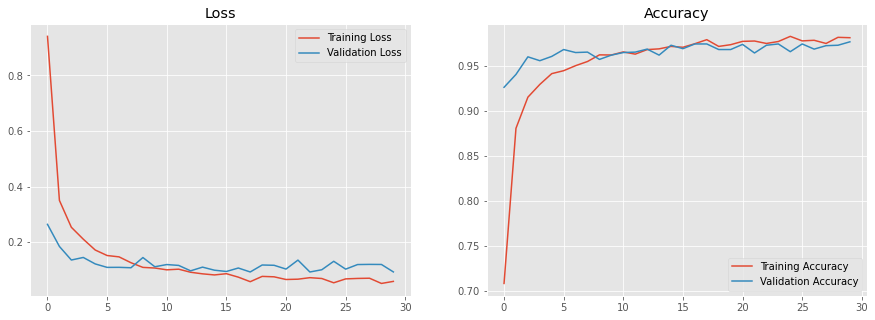

In [15]:
show_final_history(history)

In [18]:
val_pred = model_2.predict(val_images)
val_pred = np.argmax(val_pred, axis=1)
val_pred.shape

(2100,)

In [ ]:
# val_actual = val_generator.classes
# val_actual.shape

<Figure size 432x288 with 0 Axes>

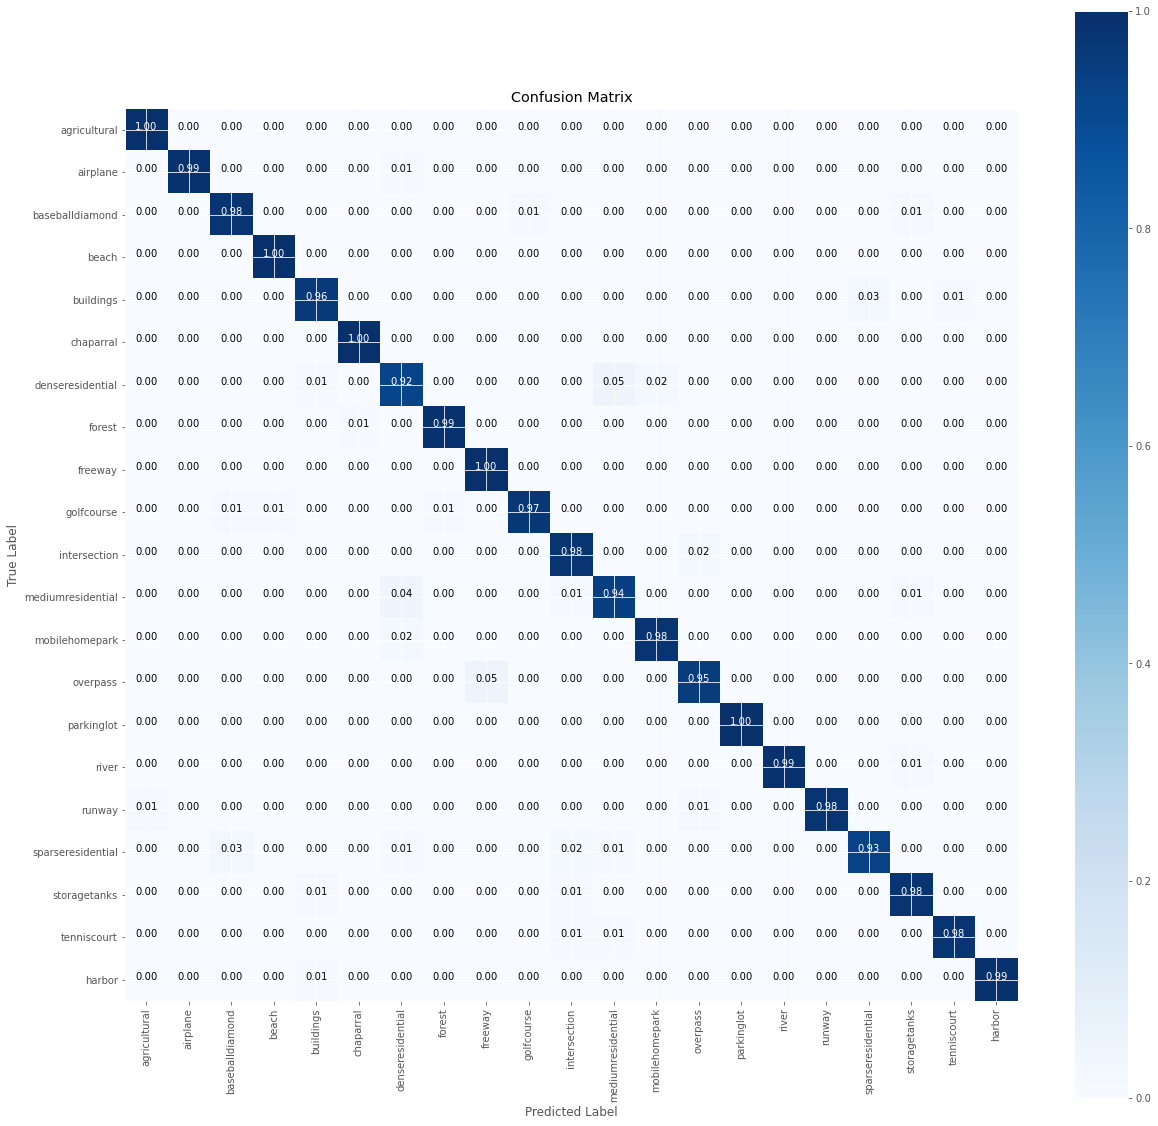

In [19]:
val_actual = np.argmax(val_labels, axis=1)

cnf_mat = confusion_matrix(val_actual, val_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat, classes=class_names)
plt.grid(None)
plt.show();

In [20]:
model_2.save("MobileNet_transfer_model.h5")